In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# your function must import layout and constants
# this is structured to work both in Jupyter notebook and from the command line
try:
    from . import layout
    from . import constants
except ImportError:
    import layout
    import constants
import logging
from random import randint
from pathlib import Path

In [7]:
import requests
from requests import exceptions as RequestException
from PIL import Image as PILImage

In [8]:
def get_comic_json(url):
    try:
        result = requests.get(url)
    except requests.exceptions.RequestException as e:
        logging.error(f'failed to fetch document at {latest_url}: {e}')
        result = None

    try: 
        json = result.json()
    except (AttributeError, ValueError) as e:
        logging.error(f'failed to decode JSON result possibly due to previous errors: {e}')
        json = {}
    return json

In [9]:
def resize_image(img, target):
    '''resize an image to match target dimensions scaling to the longest side
    
    Args:
        img(PIL Image): pillow image object
        target(tuple of int): target size in pixles'''
    logging.debug('resize image to ')
    
    idx = img.size.index(max(img.size))
    if img.size[idx] < target[idx]:
        r = target[idx]/img.size[idx]
        new_dim = [int(s * r) for s in img.size]
        new_img = img.resize(new_dim, PILImage.LANCZOS)
    else: 
        img.thumbnail(target)
        new_img = img
        
    return new_img
    

In [10]:
# make sure this function can accept *args and **kwargs even if you don't intend to use them
def update_function(self, *args, **kwargs):
    '''update function for xkcd_comic provides a comic, title and "alt-text" for a random XKCD commic
    
    During each update a random comic from the entire XKCD comic corpus. Comics are resampled to fit 
    appropriately onto the screen. 
    
    A maximum resolution of comic can be specified in the configuration (max_x, max_y). Any comic 
    larger than this maximum is rejected an another comic is chosen. This is useful because some 
    XKCD comics are enormous and cannot be resized appropriately to fit on small screens. The default 
    is 800x600 pixels.  
    
    Configuration Requirements:
        self.config(`dict`): {
            'max_x': (`int`) maximum x dimension for selected comic #optional,
            'max_y': (`int`) maximum x dimension for selected comic #optional),
            'max_retires': (`int`) number of attempts to select comic before giving up #optional,
            'resize': (0 or 1) enlarge small comics to meet max_x and max_y #optional
        }
        self.cache(`CacheFiles` object)
        
    Args:
        self(namespace): namespace from plugin object
    
    Returns:
        tuple: (is_updated(bool), data(dict), priority(int))
    %U'''   
    
    logging.debug(f'XKCD CONFIG: {self.config}')
    is_updated = False
    data = {}
    priority = 2 ** 16
    general_failure = False

    config = self.config
    # set required values if they aren't specified
    for k, v in constants.required_config.items():
        config[k] = config.get(k, v)
        # set type to match type in constants
        try:
            config[k] = type(v)(config[k])
        except ValueError as e:
            logging.warning(f'bad value in config file "{k}": {config[k]}; falling back to default value "{v}"')
            config[k] = v  

    image_path = Path(constants.image_path)

    latest_url = str.join('/', [constants.xkcd_url, constants.xkcd_json_doc])
    latest_json = get_comic_json(latest_url)
    comic_json = {}
    max_x = config['max_x']
    max_y = config['max_y']


    for i in range(0, config['max_retries']):
        # choose a random comic between 1 and latest
        try:
            random_comic = randint(1, int(latest_json['num']))
        except KeyError as e:
            logging.error(f'returned JSON data did not contain valid keys')
            random_comic = constants.default_comic

        random_comic = str(random_comic)
        random_url = str.join('/', [constants.xkcd_url, random_comic, constants.xkcd_json_doc])
        comic_json = get_comic_json(random_url)
#         filename = comic_json['img'].split('/')[-1]
        filename = comic_json.get('img', None)
        if filename:
            try:
                filename = filename.split('/')[-1]
                image_file = self.cache.cache_file(comic_json['img'], image_path/filename)
            except Exception as e:
                logging.error(f'failed to parse JSON: {comic_json}: {e}')
        else:
            logging.error(f'general failure due to bad JSON data returned by XKCD: {comic_json}')
            general_failure = True
            is_updated = False
            data = {}

        
        if not general_failure:
            try:
                image = PILImage.open(image_file)
                # reject images that are too large
                if image.size[0] < max_x and image.size[1] < max_y:
                    logging.debug(f'image size for comic {comic_json["num"]}: {image.size}')
                    comic_json['image_file'] = image_file
                    is_updated = True
                    priority = self.max_priority
                    data = comic_json

                    # resize images that are a bit too small to maximize the used space on larger displays
                    if config['resize'] == 1:
                        logging.info(f'resizing XKCD image to maximum: {max_x}, {max_y}')
                        try:
                            resized_img = resize_image(image, (max_x, max_y))
                            resized_img.save(image_file)
                            logging.debug(f'image resized to {resized_img.size}')
                        except Exception as e:
                            logging.error(f'error in resizing: {e}')
                            is_updated = False


                    break
                else:
                    logging.info(f'image for comic {comic_json["num"]} size too large: {image.size}, trying again')
                    continue
            except Exception as e:
                logging.error(f'failed to open downloaded image file: {e}')
                continue
    
    
    return (is_updated, data, priority)

In [3]:
!jupyter-nbconvert --to python --template python_clean xkcd_comic.ipynb

[NbConvertApp] Converting notebook xkcd_comic.ipynb to python
[NbConvertApp] Writing 7414 bytes to xkcd_comic.py


In [ ]:
# Jupyter notebook magic to create a symbolic to the library directory
# this will allow you to import the Plugin() module 
!ln -s ../../library ./


In [12]:
# logging.root.setLevel('DEBUG')
# from library.CacheFiles import CacheFiles
# def test_plugin():
#     '''This code snip is useful for testing a plugin from within Jupyter Notebook'''
#     from library import Plugin
#     from IPython.display import display
#     # this is set by PaperPi based on the configured schreen
#     test_plugin = Plugin(resolution=(1200, 800))
#     # this is pulled from the configuration file; the appropriate section is passed
#     # to this plugin by PaperPi during initial configuration
#     test_plugin.config = {'max_x': '900', 
#                           'max_y': '600',
#                           'max_retries': '10',
#                           'resize': 1}
#     test_plugin.layout = layout.layout
#     # this is done automatically by PaperPi when loading the plugin
#     test_plugin.cache = CacheFiles()
#     test_plugin.update_function = update_function
#     test_plugin.update()
#     display(test_plugin.image)
#     return test_plugin
# my_plugin = test_plugin

DEBUG:root:[[----checking default values for layout----]
DEBUG:root:section: [----------image_file----------]
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [----------safe_title----------]
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:section: [-------------alt--------------]
DEBUG:root:adding "font_size: None"
DEBUG:root:adding "maxchar: None"
DEBUG:root:adding "inverse: False"
DEBUG:root:adding "dimensions: None"
DEBUG:root:adding "padding: 0"
DEBUG:root:adding "fill: 0"
DEBUG:root:adding "bkground: 255"
DEBUG:root:[[....calculating layouts....]]
INFO:root:section: [..........image_file..........]
DEBUG:root:resolution: (1200, 800)
DEBUG:root:width: 1

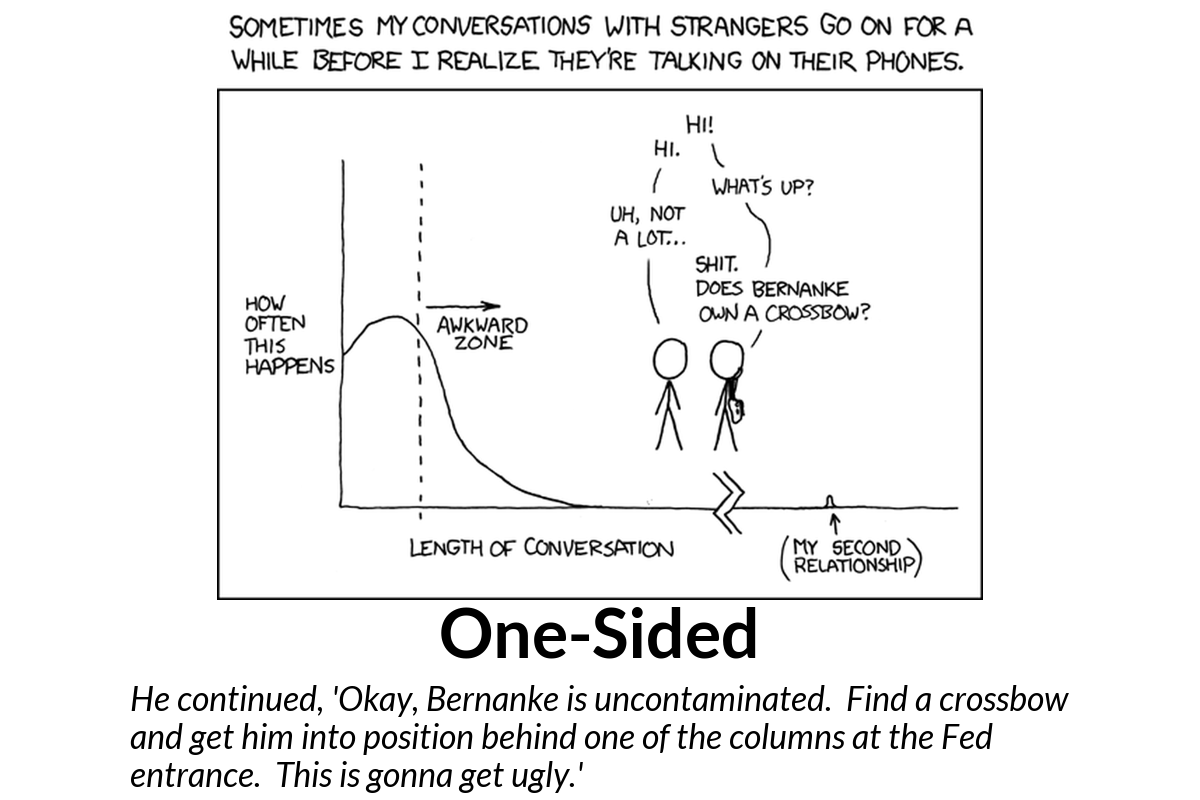

In [13]:
# this simulates calling the plugin from PaperPi
# p = my_plugin()